# 소설 작가 분류 AI 경진대회

## 0. Info

* Type : Text Classification
* URL : https://dacon.io/competitions/official/235670/data/
* score
    * train (log) :
    * val (log) :
    * test (lb) :


## 1. Setting

In [ ]:
!pip install -q sentencepiece

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa

import sentencepiece as spm
from sklearn.metrics import confusion_matrix

In [ ]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
MAX_LENGTH = 128
MODEL_DIM = 128
DFF = 128
NUM_HEAD = 4
NUM_LAYER = 4
NUM_TOKEN = 10000
DROP_RATE = 0.2
BATCH_SIZE = 32
EPOCH_SIZE = 10
BASE_DIR = 'drive/Shared drives/Yoon/Project/Doing/Data Science Competition/Dacon/Writer Classification'

## 2. Data

In [ ]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, data, tokenizer, mode):
        self.data = data
        self.tokenizer = tokenizer
        self.mode = mode

        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil(len(self.data) / BATCH_SIZE).astype(np.int32)

    def on_epoch_end(self):
        if self.mode == 'train':
            self.indices = np.random.permutation(len(self.data))
        else:
            self.indices = np.arange(len(self.data))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[BATCH_SIZE*idx : BATCH_SIZE*(idx+1)]
        batch_data = self.data.iloc[batch_idx]
        batch_x = batch_data['text']
        batch_x = [self.tokenizer.encode(x) for x in batch_x]
        batch_x = tf.keras.preprocessing.sequence.pad_sequences(batch_x, maxlen=MAX_LENGTH)
        batch_x = batch_x.astype(np.int32)

        if self.mode == 'test':
            batch_y = None
        else:
            batch_y = batch_data['author'].values.astype(np.int32)
        return batch_x, batch_y

In [ ]:
data_path = os.path.join(BASE_DIR, 'data.zip')
!unzip -q "{data_path}" -d "data"

In [ ]:
train_data = pd.read_csv('data/train.csv', index_col=0)
train_data.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [ ]:
train_data['len'] = train_data['text'].apply(len)
train_data.groupby('author')['len'].agg(['min', 'mean', 'max'])

,min,mean,max
author,,,
0,10,200.222463,1993
1,16,314.373075,2400
2,10,213.920523,1726
3,10,224.353024,2500
4,9,220.964348,1944


In [ ]:
train_data.loc[train_data['author'] == 3, 'text'].iloc[0]

'“I see: he heard I had money, and came here to marry me!”'

In [ ]:
with open('corpus.txt', 'w') as f:
    for text in train_data['text']:
        f.write(text)
        f.write('\n')

In [ ]:
input_file = 'corpus.txt'
pad_id = 0 
bos_id = 1
eos_id = 2
unk_id = 3
vocab_size = NUM_TOKEN # vocab 사이즈
prefix = 'bpe_tokenizer' # 저장될 tokenizer 모델에 붙는 이름
model_type ='bpe'

cmd = f'--input={input_file} \
--pad_id={pad_id} \
--bos_id={bos_id} \
--eos_id={eos_id} \
--unk_id={unk_id} \
--vocab_size={vocab_size} \
--model_prefix={prefix} \
--model_type={model_type}'

cmd

'--input=corpus.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --vocab_size=10000 --model_prefix=bpe_tokenizer --model_type=bpe'

In [ ]:
spm.SentencePieceTrainer.Train(cmd)

In [ ]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.load('bpe_tokenizer.model')

True

In [ ]:
split_idx = int(len(train_data) * 0.2)
random_idx = np.random.permutation(len(train_data))

train_idx = random_idx[split_idx:]
val_idx = random_idx[:split_idx]

val_data = train_data.iloc[val_idx]
train_data = train_data.iloc[train_idx]

In [ ]:
train_loader = Dataloader(train_data, tokenizer, 'train')
val_loader = Dataloader(val_data, tokenizer, 'val')

In [ ]:
x, y = train_loader.__getitem__(0)
x.shape, y.shape

((32, 128), (32,))

## 3. Model

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def gelu(x):
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.sqrt(2.0)))
    return x * cdf

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  
    return output, attention_weights


class Embedding(tf.keras.layers.Layer):
    def __init__(self, num_token, model_dim, max_len, drop_rate):
        super(Embedding, self).__init__()
        self.token_embedding = tf.keras.layers.Embedding(num_token, model_dim, mask_zero=False, input_length=max_len)
        self.pos_embedding = tf.keras.layers.Embedding(max_len, model_dim, mask_zero=False, input_length=max_len)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(drop_rate)
        self.pos = tf.range(0, max_len)
    
    def call(self, x, training):
        token_embedded = self.token_embedding(x)
        pos_embedded = self.pos_embedding(self.pos)
        pos_embedded = pos_embedded[None,:,:]
        embedded = pos_embedded + token_embedded
        embedded = self.layernorm(embedded)
        embedded = self.dropout(embedded, training=training)
        return embedded


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_head):
        super(MultiHeadAttention, self).__init__()
        self.num_head = num_head
        self.model_dim = model_dim
        self.depth = model_dim // num_head
        assert model_dim % num_head == 0

        self.wq = tf.keras.layers.Dense(model_dim)
        self.wk = tf.keras.layers.Dense(model_dim)
        self.wv = tf.keras.layers.Dense(model_dim)
        self.dense = tf.keras.layers.Dense(model_dim)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_head, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.model_dim))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)            
        return output, attention_weights


class PointWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, model_dim, dff):
        super(PointWiseFeedForward, self).__init__()
        self.dense1 = tf.keras.layers.Dense(dff)
        self.dense2 = tf.keras.layers.Dense(model_dim)
    
    def call(self, x):
        x = self.dense1(x)
        x = gelu(x)
        x = self.dense2(x)
        return x


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_head, dff, drop_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(model_dim, num_head)
        self.pwff = PointWiseFeedForward(model_dim, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)
        
    def call(self, x, mask, training):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        pwff_output = self.pwff(out1)  # (batch_size, input_seq_len, d_model)
        pwff_output = self.dropout2(pwff_output, training=training)
        out2 = self.layernorm2(out1 + pwff_output)  # (batch_size, input_seq_len, d_model)
        return out2

class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, drop_rate):
        super(OutputLayer, self).__init__()
        self.pool = tf.keras.layers.GlobalAvgPool1D()
        self.dense1 = tf.keras.layers.Dense(model_dim / 2, activation='relu')
        self.dense2 = tf.keras.layers.Dense(5, activation='softmax')
        self.dropout = tf.keras.layers.Dropout(drop_rate)
    
    def call(self, x, training):
        # x = x[:, 0]
        x = self.pool(x)
        x = self.dense1(x)
        x = self.dropout(x, training)
        x = self.dense2(x)
        return x

class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = Embedding(NUM_TOKEN, MODEL_DIM, MAX_LENGTH, DROP_RATE)
        self.encoder_layers = [EncoderLayer(MODEL_DIM, NUM_HEAD, DFF, DROP_RATE) for _ in range(NUM_LAYER)]
        self.output_layer = OutputLayer(MODEL_DIM, DROP_RATE)
    
    def call(self, x, training):
        mask = create_padding_mask(x)
        x = self.embedding(x)
        for i in range(NUM_LAYER):
            x = self.encoder_layers[i](x, mask, training)
        x = self.output_layer(x)
        return x

In [ ]:
model = Model()
_ = model(x)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     multiple                  1296640   
_________________________________________________________________
encoder_layer_36 (EncoderLay multiple                  99584     
_________________________________________________________________
encoder_layer_37 (EncoderLay multiple                  99584     
_________________________________________________________________
encoder_layer_38 (EncoderLay multiple                  99584     
_________________________________________________________________
encoder_layer_39 (EncoderLay multiple                  99584     
_________________________________________________________________
output_layer_9 (OutputLayer) multiple                  8581      
Total params: 1,703,557
Trainable params: 1,703,557
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    optimizer = tf.keras.optimizers.Adam(1e-4)
)

## 4. Train

In [ ]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    'model.h5', save_best_only=True, save_weights_only=True
)

hist = model.fit(
    train_loader,
    validation_data = val_loader,
    batch_size = BATCH_SIZE,
    epochs = EPOCH_SIZE,
    callbacks = [ckpt_callback])

Epoch 1/10
1372/1372 [==============================] - 52s 38ms/step - loss: 1.1401 - acc: 0.5470 - val_loss: 0.7999 - val_acc: 0.7021
Epoch 2/10
1372/1372 [==============================] - 53s 38ms/step - loss: 0.6969 - acc: 0.7465 - val_loss: 0.6439 - val_acc: 0.7677
Epoch 3/10
1372/1372 [==============================] - 52s 38ms/step - loss: 0.5404 - acc: 0.8067 - val_loss: 0.5924 - val_acc: 0.7926
Epoch 4/10
1372/1372 [==============================] - 52s 38ms/step - loss: 0.4494 - acc: 0.8397 - val_loss: 0.6176 - val_acc: 0.7933
Epoch 5/10
1372/1372 [==============================] - 52s 38ms/step - loss: 0.3842 - acc: 0.8624 - val_loss: 0.6294 - val_acc: 0.7959
Epoch 6/10
1372/1372 [==============================] - 52s 38ms/step - loss: 0.3387 - acc: 0.8810 - val_loss: 0.6345 - val_acc: 0.7964
Epoch 7/10
1372/1372 [==============================] - 53s 38ms/step - loss: 0.2988 - acc: 0.8964 - val_loss: 0.7063 - val_acc: 0.7924
Epoch 8/10
1372/1372 [==========================

train loss : 0.3384 | val loss : 0.5924
train acc  : 0.8817  | val acc  : 0.7926


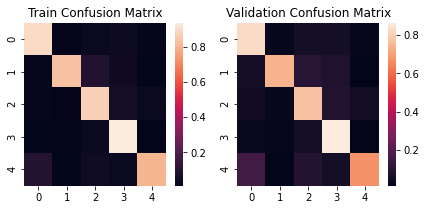

In [ ]:
model.load_weights('model.h5')

train_true = train_data['author']
train_loader = Dataloader(train_data, tokenizer, 'test')
train_prob = model.predict(train_loader)
train_pred = np.argmax(train_prob, axis=1)
train_loss = np.mean(tf.keras.losses.sparse_categorical_crossentropy(train_true, train_prob))
train_acc = np.mean(train_true == train_pred)

val_true = val_data['author']
val_loader = Dataloader(val_data, tokenizer, 'test')
val_prob = model.predict(val_loader)
val_pred = np.argmax(val_prob, axis=1)
val_loss = np.mean(tf.keras.losses.sparse_categorical_crossentropy(val_true, val_prob))
val_acc = np.mean(val_true == val_pred)

train_cfm = confusion_matrix(train_true, train_pred, normalize='true')
val_cfm = confusion_matrix(val_true, val_pred, normalize='true')

print(f'train loss : {train_loss:.4f} | val loss : {val_loss:.4f}')
print(f'train acc  : {train_acc:.4f}  | val acc  : {val_acc:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(7, 3))
sns.heatmap(train_cfm, ax=ax[0])
sns.heatmap(val_cfm, ax=ax[1])

ax[0].set_title('Train Confusion Matrix')
ax[1].set_title('Validation Confusion Matrix')
plt.show()

## 5. Test

In [ ]:
test_data = pd.read_csv('data/test_x.csv')
test_data.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0


In [ ]:
test_loader = Dataloader(test_data, tokenizer, 'test')
test_pred = model.predict(test_loader)
submission[['0', '1', '2', '3', '4']] = test_pred

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.head()

,index,0,1,2,3,4
0,0,0.010309,0.783180,0.200585,0.005426,0.000500
1,1,0.001642,0.993249,0.000248,0.004015,0.000847
2,2,0.998716,0.000881,0.000239,0.000046,0.000119
3,3,0.005959,0.007133,0.950626,0.000124,0.036159
4,4,0.995304,0.003235,0.000139,0.000994,0.000328
